# Link prediction with attri2vec

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/attri2vec-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/attri2vec-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

This demo notebook demonstrates how to predict citation links/edges between papers using attri2vec on the Cora dataset.

We're going to tackle link prediction as a supervised learning problem on top of node representations/embeddings. The embeddings are computed with the unsupervised attri2vec algorithm. After obtaining embeddings, a binary classifier can be used to predict a link, or not, between any two nodes in the graph. Various hyperparameters could be relevant in obtaining the best link classifier - this demo demonstrates incorporating model selection into the pipeline for choosing the best binary operator to apply on a pair of node embeddings.

There are four steps:

1. Obtain embeddings for each node
2. For each set of hyperparameters, train a classifier
3. Select the classifier that performs the best
4. Evaluate the selected classifier on unseen data to validate its ability to generalise

<a name="refs"></a>
**References:** 

[1] Attributed Network Embedding via Subspace Discovery. D. Zhang, Y. Jie, X. Zhu and C. Zhang. Data Mining and Knowledge Discovery, 2019. 

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.1.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.1.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.1.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import matplotlib.pyplot as plt
from math import isclose
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from stellargraph import StellarGraph, datasets
from stellargraph.data import EdgeSplitter
from collections import Counter
import multiprocessing
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split

%matplotlib inline

## Load the dataset

The Cora dataset is a homogeneous network where all nodes are papers and edges between nodes are citation links, e.g. paper A cites paper B.

(See [the "Loading from Pandas" demo](../basics/loading-pandas.ipynb) for details on how data can be loaded.)

In [4]:
dataset = datasets.Cora()
display(HTML(dataset.description))
graph, _ = dataset.load(largest_connected_component_only=True, str_node_ids=True)

In [5]:
print(graph.info())

StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 5209

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5209]
        Weights: all 1 (default)


## Construct splits of the input data

We have to carefully split the data to avoid data leakage and evaluate the algorithms correctly:

* For computing node embeddings, a **Train Graph** (`graph_train`)
* For training classifiers, a classifier **Training Set** (`examples_train`) of positive and negative edges that weren't used for computing node embeddings
* For choosing the best classifier, an **Model Selection Test Set** (`examples_model_selection`) of positive and negative edges that weren't used for computing node embeddings or training the classifier 
* For the final evaluation, a **Test Graph** (`graph_test`) to compute test node embeddings with more edges than the Train Graph, and a **Test Set** (`examples_test`) of positive and negative edges not used for neither computing the test node embeddings or for classifier training or model selection

###  Test Graph

We begin with the full graph and use the `EdgeSplitter` class to produce:

* Test Graph
* Test set of positive/negative link examples

The Test Graph is the reduced graph we obtain from removing the test set of links from the full graph.

In [6]:
# Define an edge splitter on the original graph:
edge_splitter_test = EdgeSplitter(graph)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from graph, and obtain the
# reduced graph graph_test with the sampled links removed:
graph_test, examples_test, labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
)

print(graph_test.info())

** Sampled 520 positive and 520 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4689

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4689]
        Weights: all 1 (default)


### Train Graph

This time, we use the `EdgeSplitter` on the Test Graph, and perform a train/test split on the examples to produce:

* Train Graph
* Training set of link examples
* Set of link examples for model selection


In [7]:
# Do the same process to compute a training subset from within the test graph
edge_splitter_train = EdgeSplitter(graph_test, graph)
graph_train, examples, labels = edge_splitter_train.train_test_split(
    p=0.1, method="global"
)
(
    examples_train,
    examples_model_selection,
    labels_train,
    labels_model_selection,
) = train_test_split(examples, labels, train_size=0.75, test_size=0.25)

print(graph_train.info())

** Sampled 468 positive and 468 negative edges. **
StellarGraph: Undirected multigraph
 Nodes: 2485, Edges: 4221

 Node types:
  paper: [2485]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4221]
        Weights: all 1 (default)


Below is a summary of the different splits that have been created in this section

In [8]:
pd.DataFrame(
    [
        (
            "Training Set",
            len(examples_train),
            "Train Graph",
            "Test Graph",
            "Train the Link Classifier",
        ),
        (
            "Model Selection",
            len(examples_model_selection),
            "Train Graph",
            "Test Graph",
            "Select the best Link Classifier model",
        ),
        (
            "Test set",
            len(examples_test),
            "Test Graph",
            "Full Graph",
            "Evaluate the best Link Classifier",
        ),
    ],
    columns=("Split", "Number of Examples", "Hidden from", "Picked from", "Use"),
).set_index("Split")

,Number of Examples,Hidden from,Picked from,Use
Split,,,,
Training Set,702,Train Graph,Test Graph,Train the Link Classifier
Model Selection,234,Train Graph,Test Graph,Select the best Link Classifier model
Test set,1040,Test Graph,Full Graph,Evaluate the best Link Classifier


## attri2vec

We use attri2vec [[1]](#refs), to calculate node embeddings. These embeddings are learned in such a way to preserve the similarity measured by both network structure and node content features. With the node content features are used to learn node embeddings, we wish that attri2vec can achieve better link prediction performance than the only structure preserving network embedding baselines like Node2Vec.

These are the set of parameters we can use:


* `dimensions` - Dimensionality of attri2vec embeddings
* `num_walks` - Number of walks from each node
* `walk_length` - Length of each random walk
* `batch_size` * - The batch size to train attri2vec
* `epochs` * - The number of epochs to train attri2vec

In [9]:
dimensions = 128
num_walks = 4
walk_length = 5
batch_size = 50
epochs = 6

In [10]:
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification
from tensorflow import keras


def attri2vec_embedding(graph, name):

    print(f"Training attri2vec for '{name}:'")

    # Create the unsupervised sampler to sample (target, context) pairs from uniform random walks
    unsupervised_samples = UnsupervisedSampler(
        graph, nodes=list(graph.nodes()), length=walk_length, number_of_walks=num_walks
    )

    # Define an attri2vec training generator, which generates batches of training pairs
    generator = Attri2VecLinkGenerator(graph, batch_size)

    # Create the attri2vec model
    attri2vec = Attri2Vec(
        layer_sizes=[dimensions], generator=generator, bias=False, normalize=None
    )

    # Build the model and expose input and output sockets of attri2vec, for node pair inputs
    x_inp, x_out = attri2vec.in_out_tensors()

    # Use the link_classification function to generate the output of the attri2vec model
    prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
    )(x_out)

    # Stack the attri2vec encoder and prediction layer into a Keras model, and specify the loss
    model = keras.Model(inputs=x_inp, outputs=prediction)
    model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

    # Train the model
    history = model.fit(
        generator.flow(unsupervised_samples),
        epochs=epochs,
        verbose=2,
        use_multiprocessing=False,
        workers=1,
        shuffle=True,
    )

    # Build the model to predict node representations from node features with the learned attri2vec parameters
    x_inp_src = x_inp[0]
    x_out_src = x_out[0]
    embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

    # Get representations for all nodes in ``graph``
    node_gen = Attri2VecNodeGenerator(graph, batch_size).flow(list(graph.nodes()))
    node_embeddings = embedding_model.predict(node_gen, workers=1, verbose=0)

    def get_embedding(u):
        u_index = list(graph.nodes()).index(u)
        return node_embeddings[u_index]

    return get_embedding

In [11]:
embedding_train = attri2vec_embedding(graph_train, "Train Graph")

Training attri2vec for 'Train Graph:'
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Train for 1535 steps
Epoch 1/6
1535/1535 - 4s - loss: 0.7001 - binary_accuracy: 0.5327
Epoch 2/6
1535/1535 - 4s - loss: 0.6245 - binary_accuracy: 0.6511
Epoch 3/6
1535/1535 - 4s - loss: 0.4549 - binary_accuracy: 0.8111
Epoch 4/6
1535/1535 - 4s - loss: 0.3235 - binary_accuracy: 0.8852
Epoch 5/6
1535/1535 - 4s - loss: 0.2447 - binary_accuracy: 0.9203
Epoch 6/6
1535/1535 - 4s - loss: 0.1901 - binary_accuracy: 0.9426


## Train and evaluate the link prediction model

There are a few steps involved in using the attri2vec model to perform link prediction:
1. We calculate link/edge embeddings for the positive and negative edge samples by applying a binary operator on the embeddings of the source and target nodes of each sampled edge.
2. Given the embeddings of the positive and negative examples, we train a logistic regression classifier to predict a binary value indicating whether an edge between two nodes should exist or not.
3. We evaluate the performance of the link classifier for each of the 4 operators on the training data with node embeddings calculated on the **Train Graph** (`graph_train`), and select the best classifier.
4. The best classifier is then used to calculate scores on the test data with node embeddings calculated on the **Test Graph** (`graph_test`).

Below are a set of helper functions that let us repeat these steps for each of the binary operators.

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler


# 1. link embeddings
def link_examples_to_features(link_examples, transform_node, binary_operator):
    return [
        binary_operator(transform_node(src), transform_node(dst))
        for src, dst in link_examples
    ]


# 2. training classifier
def train_link_prediction_model(
    link_examples, link_labels, get_embedding, binary_operator
):
    clf = link_prediction_classifier()
    link_features = link_examples_to_features(
        link_examples, get_embedding, binary_operator
    )
    clf.fit(link_features, link_labels)
    return clf


def link_prediction_classifier(max_iter=2000):
    lr_clf = LogisticRegressionCV(Cs=10, cv=10, scoring="roc_auc", max_iter=max_iter)
    return Pipeline(steps=[("sc", StandardScaler()), ("clf", lr_clf)])


# 3. and 4. evaluate classifier
def evaluate_link_prediction_model(
    clf, link_examples_test, link_labels_test, get_embedding, binary_operator
):
    link_features_test = link_examples_to_features(
        link_examples_test, get_embedding, binary_operator
    )
    score = evaluate_roc_auc(clf, link_features_test, link_labels_test)
    return score


def evaluate_roc_auc(clf, link_features, link_labels):
    predicted = clf.predict_proba(link_features)

    # check which class corresponds to positive links
    positive_column = list(clf.classes_).index(1)
    return roc_auc_score(link_labels, predicted[:, positive_column])

We consider 4 different operators: 

* *Hadamard*
* $L_1$
* $L_2$
* *average*

The paper [[1]](#refs) provides a detailed description of these operators. All operators produce link embeddings that have equal dimensionality to the input node embeddings (128 dimensions for our example). 

In [13]:
def operator_hadamard(u, v):
    return u * v


def operator_l1(u, v):
    return np.abs(u - v)


def operator_l2(u, v):
    return (u - v) ** 2


def operator_avg(u, v):
    return (u + v) / 2.0


def run_link_prediction(binary_operator):
    clf = train_link_prediction_model(
        examples_train, labels_train, embedding_train, binary_operator
    )
    score = evaluate_link_prediction_model(
        clf,
        examples_model_selection,
        labels_model_selection,
        embedding_train,
        binary_operator,
    )

    return {"classifier": clf, "binary_operator": binary_operator, "score": score}


binary_operators = [operator_hadamard, operator_l1, operator_l2, operator_avg]

In [14]:
results = [run_link_prediction(op) for op in binary_operators]
best_result = max(results, key=lambda result: result["score"])

print(f"Best result from '{best_result['binary_operator'].__name__}'")

pd.DataFrame(
    [(result["binary_operator"].__name__, result["score"]) for result in results],
    columns=("name", "ROC AUC score"),
).set_index("name")

Best result from 'operator_l1'


,ROC AUC score
name,
operator_hadamard,0.923611
operator_l1,0.933991
operator_l2,0.929094
operator_avg,0.514839


### Evaluate the best model using the test set

Now that we've trained and selected our best model, we use a test set of embeddings and calculate a final evaluation score.

In [15]:
embedding_test = attri2vec_embedding(graph_test, "Test Graph")

Training attri2vec for 'Test Graph:'
link_classification: using 'ip' method to combine node embeddings into edge embeddings
Train for 1563 steps
Epoch 1/6
1563/1563 - 5s - loss: 0.6999 - binary_accuracy: 0.5367
Epoch 2/6
1563/1563 - 5s - loss: 0.6268 - binary_accuracy: 0.6486
Epoch 3/6
1563/1563 - 4s - loss: 0.4595 - binary_accuracy: 0.8060
Epoch 4/6
1563/1563 - 4s - loss: 0.3300 - binary_accuracy: 0.8799
Epoch 5/6
1563/1563 - 4s - loss: 0.2516 - binary_accuracy: 0.9148
Epoch 6/6
1563/1563 - 4s - loss: 0.1974 - binary_accuracy: 0.9396


In [16]:
test_score = evaluate_link_prediction_model(
    best_result["classifier"],
    examples_test,
    labels_test,
    embedding_test,
    best_result["binary_operator"],
)
print(
    f"ROC AUC score on test set using '{best_result['binary_operator'].__name__}': {test_score}"
)

ROC AUC score on test set using 'operator_l1': 0.9305473372781065


### Visualise representations of link embeddings

Learned link embeddings have 128 dimensions but for visualisation we project them down to 2 dimensions using the PCA algorithm ([link](https://en.wikipedia.org/wiki/Principal_component_analysis)). 

Blue points represent positive edges and red points represent negative (no edge should exist between the corresponding vertices) edges.

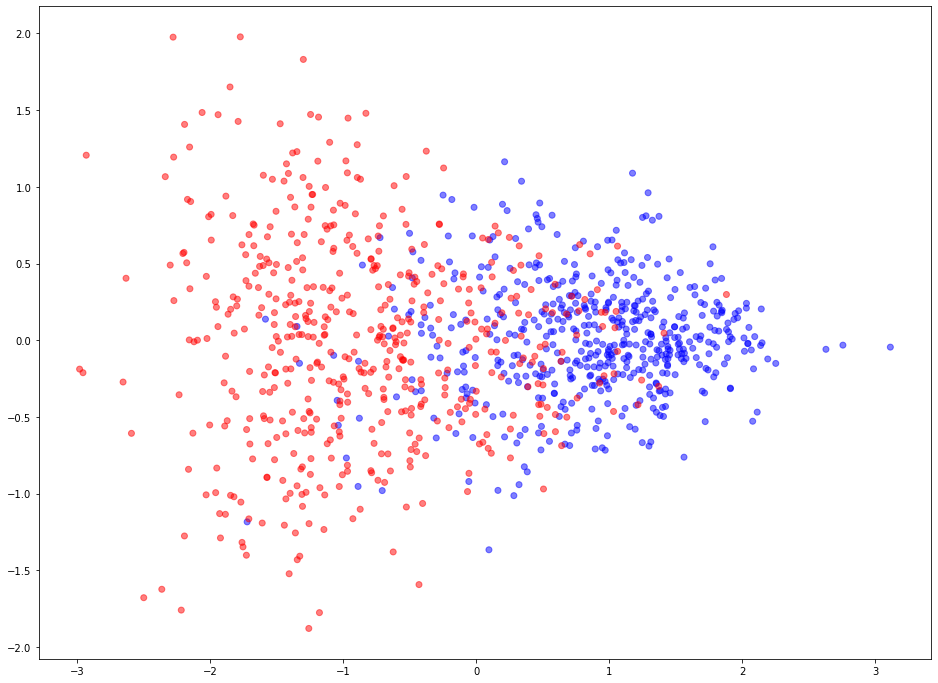

In [17]:
# Calculate edge features for test data
link_features = link_examples_to_features(
    examples_test, embedding_test, best_result["binary_operator"]
)

# Learn a projection from 128 dimensions to 2
pca = PCA(n_components=2)
X_transformed = pca.fit_transform(link_features)

# plot the 2-dimensional points
plt.figure(figsize=(16, 12))
plt.scatter(
    X_transformed[:, 0],
    X_transformed[:, 1],
    c=np.where(labels_test == 1, "b", "r"),
    alpha=0.5,
)

This example has demonstrated how to use the `stellargraph` library to build a link prediction algorithm for homogeneous graphs using the attri2vec, [1], representation learning algorithm.

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/link-prediction/attri2vec-link-prediction.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/link-prediction/attri2vec-link-prediction.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>